<a href="https://colab.research.google.com/github/shadaabghani1/assignments/blob/main/Datadivr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will try to build a product-specific compliance scoring for evaluating the product “Gatorade”.

In this excercise we are supplied with the product shelves images. We will be utilizing the images to firstly calculate the number of shelves in each image along with the number of products in each shelf.

Subsequently we will look into each shelf and find the number of gatorade products.

As the number of images is very low for training or finetuning any model, we will continue to use baseline models for this task. I will be mentioning parts of the code which will benefit using finetuned models.

###### Reading of an image

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
from google.colab.patches import cv2_imshow

In [3]:
img = cv.imread('/content/image_1.png')

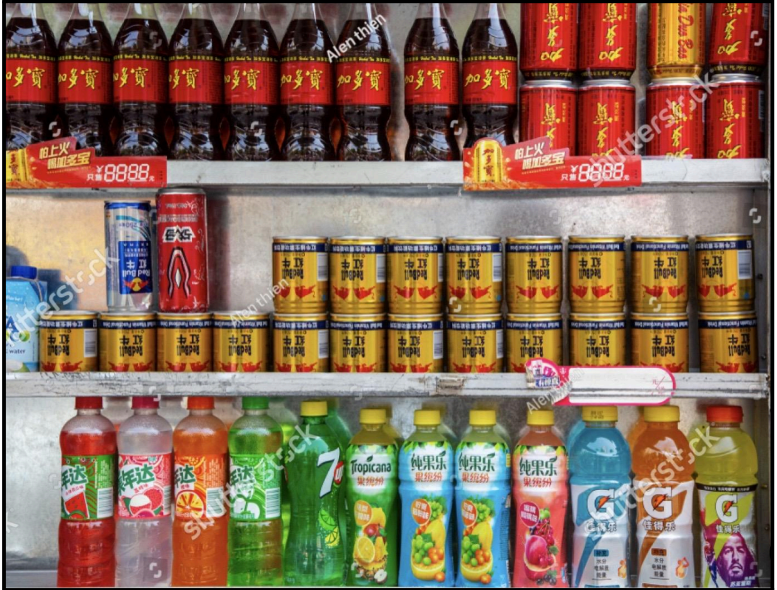

In [4]:
cv2_imshow(img)

###### Using YOLO v8 to calculate the number of shelves and products in each shelves

In [5]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.0/705.0 kB 9.7 MB/s eta 0:00:00


In [6]:
import numpy as np
from ultralytics import YOLO

###### Get the bounding boxes from YOLO v8 model

In [7]:
model = YOLO('yolov8n.pt')
result=model.predict(
   source='/content/image_1.png',
   conf=0.45,
    save=True
)

100%|██████████| 6.23M/6.23M [00:00<00:00, 27.1MB/s]



image 1/1 /content/image_1.png: 512x640 12 bottles, 1 refrigerator, 391.9ms
Speed: 18.3ms preprocess, 391.9ms inference, 33.0ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict


In [18]:
def generate_shelf_count(result) :
  arrxy=result[0].boxes.xyxy
  coordinates = np.array(arrxy)
  arrxy=result[0].boxes.xyxy
  coordinates = np.array(arrxy)

  ### Find the midpoints for each box and create a sorted array of midpoints
  x_coords = (coordinates[:, 0] + coordinates[:, 2]) / 2

  y_coords = (coordinates[:, 1] + coordinates[:, 3]) / 2

  midpoints = np.column_stack((x_coords, y_coords))

  rounded_n_sorted_arr = np.round(midpoints[midpoints[:, 1].argsort()]).astype(int)

  ##### Get total number of shelves and products in each shelf

  count=1
  objects=0
  group_sizes = []

  for i in range(1, len(rounded_n_sorted_arr)):
      #### 140 is the pixel distance between each shelf
      if(rounded_n_sorted_arr[i][1] - rounded_n_sorted_arr[i-1][1] > 140 ):

          group_sizes.append(objects + 1)
          count += 1
          objects = 0

      else:
          objects += 1

  group_sizes.append(objects + 1)

  return group_sizes

In [32]:
group_sizes_image = generate_shelf_count(result)

In [20]:
for i, size in enumerate(group_sizes_image):
    print(f" There are {size} products on {i+1}. shelf")

 There are 3 products on 1. shelf
 There are 1 products on 2. shelf
 There are 9 products on 3. shelf


Total number of shelves we see is 3.

For finding the matches of gatorade, we will get the image of each shelf and use Brute-Force Matching with SIFT Descriptors and Ratio Test to get the number of matches.

This method does not require any pretraining and hence we are using this method. If adequate number of images are available, we will be using YOLO for the task.

Let us first reach the gatorade image that needs to be merged

In [11]:
match_image = cv.imread('/content/search_image.png')

In [12]:
cv2_imshow(match_image)

##### Dividing the image into 3 parts as there are three rows. We will us the last row for our matching exercise and we know gatorade is present there

In [13]:
img.shape

(590, 777, 3)

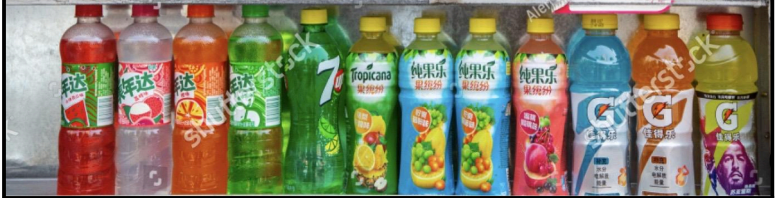

In [17]:
cv2_imshow(img[(590//3)*2 :: , : , :])

##### we can observe that when dividing the image, we have successfully been able to get the bottom image value

In [21]:
img2 = img[(590//3)*2 :: , : , :]

In [22]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(cv.cvtColor(match_image, cv.COLOR_BGR2GRAY) ,None)
kp2, des2 = sift.detectAndCompute(cv.cvtColor(img2, cv.COLOR_BGR2GRAY),None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

In [31]:
len(good)

1

In [29]:
img3 = cv.drawMatchesKnn(match_image,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

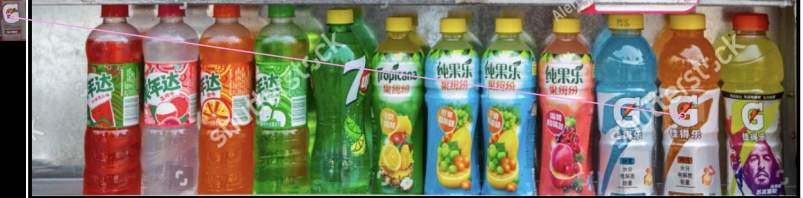

In [30]:
cv2_imshow(img3)

Voila!! we can see that SIFT method has matched for Gatorade. Let us now generalize this for the whole image

In [33]:
img.shape[0]

590

In [38]:
goodmatches = []

In [39]:
for i in range(len(group_sizes_image)) :
  value = img.shape[0]//len(group_sizes_image)

  img2 = img[(value)*(i) :(value)*(i+1) , : , :]
  sift = cv.SIFT_create()
  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(cv.cvtColor(match_image, cv.COLOR_BGR2GRAY) ,None)
  kp2, des2 = sift.detectAndCompute(cv.cvtColor(img2, cv.COLOR_BGR2GRAY),None)
  # BFMatcher with default params
  bf = cv.BFMatcher()
  matches = bf.knnMatch(des1,des2,k=2)
  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append([m])

  goodmatches.append(len(good))

Let us now implement mark if the product is compliant , non-compliant or highly non-compliant

In [42]:
## To check if the product is present at the bottom , we check if the last index has any matches or not. If matched then the it is Non Compliant
if goodmatches[-1]!= 0 :
  print('non-compliant')

## To check if the product is highly non compliant, we will look at each shelf, the total number of products present and make sure it less than the number of matches.
highly_non_compliant = False
for i in range(len(group_sizes_image)) :
  if group_sizes_image[i] > goodmatches[i] :
    print('Highly Non Compliant')
    break

## To check if the product is highly compliant then, we will have to keep the count of number of racks its present or see if its present in the first two racks

count = 0

for i in range(len(group_sizes_image)) :
  if group_sizes_image[i] == goodmatches[i] :
    count +=1
  if count == 2 :
    print('Compliant')
    break

non-compliant
Highly Non Compliant


The image we see is highly non compliant.

Let us now try for another image

In [48]:
img = cv.imread('/content/image_3.png')

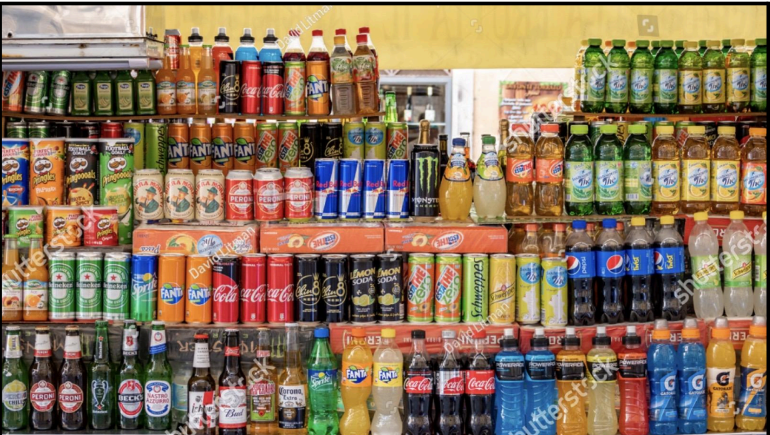

In [49]:
cv2_imshow(img)

Getting the number of shelves

In [51]:
result=model.predict(
   source='/content/image_3.png',
   conf=0.45,
    save=True
)


image 1/1 /content/image_3.png: 384x640 12 bottles, 186.1ms
Speed: 3.7ms preprocess, 186.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


In [53]:
group_sizes_image = generate_shelf_count(result)

In [54]:
for i, size in enumerate(group_sizes_image):
    print(f" There are {size} products on {i+1}. shelf")

 There are 6 products on 1. shelf
 There are 6 products on 2. shelf


In [55]:
goodmatches = []
for i in range(len(group_sizes_image)) :
  value = img.shape[0]//len(group_sizes_image)

  img2 = img[(value)*(i) :(value)*(i+1) , : , :]
  sift = cv.SIFT_create()
  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(cv.cvtColor(match_image, cv.COLOR_BGR2GRAY) ,None)
  kp2, des2 = sift.detectAndCompute(cv.cvtColor(img2, cv.COLOR_BGR2GRAY),None)
  # BFMatcher with default params
  bf = cv.BFMatcher()
  matches = bf.knnMatch(des1,des2,k=2)
  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append([m])

  goodmatches.append(len(good))

In [56]:
## To check if the product is present at the bottom , we check if the last index has any matches or not. If matched then the it is Non Compliant
if goodmatches[-1]!= 0 :
  print('non-compliant')

## To check if the product is highly non compliant, we will look at each shelf, the total number of products present and make sure it less than the number of matches.
highly_non_compliant = False
for i in range(len(group_sizes_image)) :
  if group_sizes_image[i] > goodmatches[i] :
    print('Highly Non Compliant')
    break

## To check if the product is highly compliant then, we will have to keep the count of number of racks its present or see if its present in the first two racks

count = 0

for i in range(len(group_sizes_image)) :
  if group_sizes_image[i] == goodmatches[i] :
    count +=1
  if count == 2 :
    print('Compliant')
    break

Highly Non Compliant
